In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import glob
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from docx import Document
from docx.shared import Inches
os.chdir('C:/Users/yashg/OneDrive/Desktop/CMU/Fall 2020/Energy_Hackathon/DLC Datasets for Hackathon/')

# Functions:

### Task 1

In [72]:
def plots(data):
    tvols=[x for x in data.columns if 'ETRM' in x]
    pows=[x for x in data.columns if 'POWR' in x]
    spe=[x for x in data.columns if 'SPD' in x]
    bvols=[x for x in data.columns if 'VOLT' in x]
    plt.plot(data['Time(s)'],np.array([data[x] for x in tvols]).T)
    lgd=plt.legend(tvols,bbox_to_anchor=(0.7, -0.15))
    plt.xlabel('Time (seconds)')
    plt.title('Generator terminal voltage')
    plt.savefig('docs/genvol.jpg',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.plot(data['Time(s)'],np.array([data[x] for x in pows]).T)
    lgd=plt.legend(pows,bbox_to_anchor=(0.7, -0.15))
    plt.xlabel('Time (seconds)')
    plt.title('Generator power')
    plt.savefig('docs/genpow.jpg',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.plot(data['Time(s)'],np.array([data[x] for x in spe]).T)
    lgd=plt.legend(spe,bbox_to_anchor=(0.7, -0.15))
    plt.xlabel('Time (seconds)')
    plt.title('Generator speed')
    plt.savefig('docs/gensp.jpg',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.plot(data['Time(s)'],np.array([data[x] for x in bvols]).T)
    lgd=plt.legend(bvols,bbox_to_anchor=(0.7, -0.15))
    plt.xlabel('Time (seconds)')
    plt.title('Bus Voltages')
    plt.savefig('docs/genbus.jpg',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    return None

### Task 2

In [13]:
def gen_busvoltage_data(data):
    bvols=[x for x in data.columns if 'VOLT' in x]
    bvols=['Time(s)']+bvols
    dat=data[bvols]
    return dat

def gen_termvoltage_data(data):
    bvols=[x for x in data.columns if 'ETRM' in x]
    bvols=['Time(s)']+bvols
    dat=data[bvols]
    return dat

def gen_genpow_data(data):
    bvols=[x for x in data.columns if 'POWR' in x]
    bvols=['Time(s)']+bvols
    dat=data[bvols]
    return dat

def gen_speed_data(data):
    bvols=[x for x in data.columns if 'SPD' in x]
    bvols=['Time(s)']+bvols
    dat=data[bvols]
    return dat

def get_disturbance(data):
    vols=gen_busvoltage_data(data)
    dis=[]
    tim=vols['Time(s)']
    for x in vols:
        if 'Time' not in x:
            temp=vols[x]
            for i in range(1,len(temp)):
                if temp[i-1]-temp[i]>1e-3:
                    dis.append(tim[i])
                    break  
    return np.min(dis)

### Task 3

In [14]:
def check_total_stability_power(data):
    dd=gen_genpow_data(data)
    t=dd.iloc[:,0]
    d2=dd.iloc[:,1:]
    c=[]
    for i in d2:
        ind=find_peaks(dd[i])[0]
        p=[dd[i][k] for k in ind] 
        p1=find_peaks(p)[0]     
        if len(p1)<2:
            c.append(1)
        else:
            c.append(-1)
    return c

def check_total_stability_voltage(data):
    dd=gen_termvoltage_data(data)
    t=dd.iloc[:,0]
    d2=dd.iloc[:,1:]
    c=[]
    for i in d2:
        ind=find_peaks(dd[i])[0]
        p=[dd[i][k] for k in ind] 
        p1=find_peaks(p)[0]     
        if len(p1)<2:
            c.append(1)
        else:
            c.append(-1)
    return c

def check_total_stability_speed(data):
    dd=gen_speed_data(data)
    t=dd.iloc[:,0]
    d2=dd.iloc[:,1:]
    c=[]
    for i in d2:
        ind=find_peaks(dd[i])[0]
        p=[dd[i][k] for k in ind] 
        p1=find_peaks(p)[0]     
        if len(p1)<2:
            c.append(1)
        else:
            c.append(-1)
    return c

def all_constraints(data):
    l=[check_total_stability_speed(data)+check_total_stability_voltage(data) \
      +check_total_stability_power(data)]
    p=[item for sublist in l for item in sublist]
    if np.sum(p)>0:
        return 1
    elif np.sum(p)<0:
        return -1
    else:
        print('Error')
        return 0

### Task 4

In [31]:
def recovery_time(data):
    st=all_constraints(data)
    u=''
    if st==-1:
        print ('Unstable dataset: No recovery time defined')
        u=u+ 'Unstable dataset: No recovery time defined'
    elif st==1:
        dd=gen_termvoltage_data(data)
        t=dd.iloc[:,0]
        vols=dd.iloc[:,1:]
        start=get_disturbance(data)
        for i in vols:
            v=np.argwhere(vols[i]<0.7)
            if len(v)==0:
                u=u+f'Recovery time for {i}: 0 s ->PJM Criteria satisfied'+'\n'
                print(f'Recovery time for {i}: 0 s ->PJM Criteria satisfied')
            elif len(v)>1:
                beg=t[v[0]-1]
                end=t[v[-1]+1]
                tot=end-beg
                if tot<=2.5:
                    q='PJM Criteria satisfied'
                else:
                    q='PJM Criteria NOT satisfied'
                u=u+f'Recovery time for {i}: {tot} s -> {q}'
                print(f'Recovery time for {i}: {tot} s -> {q}')
    return u        

### Task 5

In [32]:
def prony(t,*pars):
    A,s1,B,s2,w2,phi=pars
    output=A*np.exp(s1*t)+B*np.exp(s2*t)*np.cos(((w2*t+phi)))
    return output

def damping(data,low=30,up=40):
    u=''
    st=all_constraints(data)
    if st==-1:
        u=u+'Unstable dataset: No damping defined'
        print('Unstable dataset: No damping defined')
    spe=[x for x in data.columns if 'SPD' in x]
    tg=data['Time(s)']
    ind2=tg.index[(tg>=low)&(tg<=up)]
    tg2=tg[ind2]
    for s in spe:
        sample1=data[s][ind2]
        popt, pcov = curve_fit(prony, tg2, sample1,p0=np.array([-0.00196,-0.0015805,0.0003266,-0.0648,2.90167,6]))
        A,s1,B,s2,w2,phi=popt
        per=s2/np.sqrt(s2**2+w2**2)*100
        if per<=3:
            q='PJM Criteria satisfied'
        else:
            q='PJM Criteria NOT satisfied'    
        u=u+f'{s}:{per:1.2f}% -> {q}'+'\n'
        print(f'{s}:{per:1.2f}% -> {q}')
    return u

### Compilation

In [73]:
def compile(n):
    inp=''
    print(f'---------Simulation Number:{n}------------')
    data=pd.read_csv(f'{n}.csv')
    print('Task 1: Create graphic plot of power system variables')
    plots(data)
    inp=inp+'Task 2: Identify the time at which the disturbance occurs'+'\n'
    print('Task 2: Identify the time at which the disturbance occurs')
    tm=get_disturbance(data)
    inp=inp+f'Time of disturbance:{tm:1.2f}'+'\n'
    print(f'Time of disturbance:{tm:1.2f}')
    inp=inp+f'----------------------'+'\n'
    print(f'----------------------')
    inp+='Task 3: Identify whether or not the system remains stable'+'\n'
    print('Task 3: Identify whether or not the system remains stable')
    co=all_constraints(data)
    if co==-1:
        inp+='Unstable system\nTask 4 & 5: Skipped\n----------------------'
        print('Unstable system')
        print('Task 4 & 5: Skipped')
        print(f'----------------------')
    elif co==1:
        inp+='It is a stable system\n----------------------\nTask 4: Do all voltages restore in accordance with PJM criteria?\n'
        print('It is a stable system')
        print(f'----------------------')
        print('Task 4: Do all voltages restore in accordance with PJM criteria?Task 5: Does the system stabilize with sufficient damping per PJM criteria?\n')
        inp+=recovery_time(data)+'\n----------------------\n'
        print(f'----------------------')
        print('Task 5: Does the system stabilize with sufficient damping per PJM criteria?')
        inp+=damping(data)+'\n'
        print(f'----------------------')
    elif co==0:
        print('Some error')
    return inp

---------Simulation Number:72------------
Task 1: Create graphic plot of power system variables


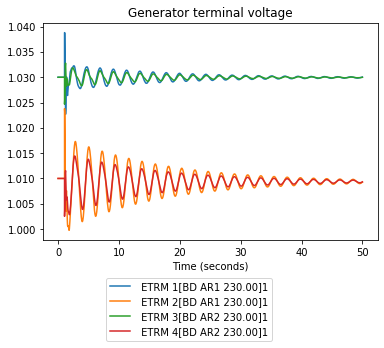

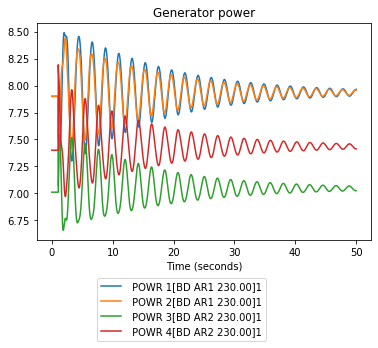

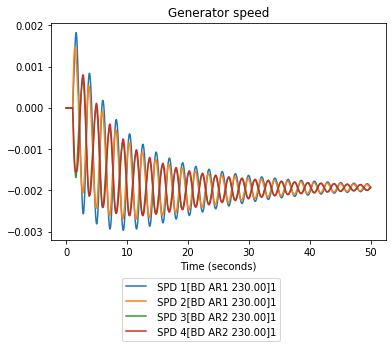

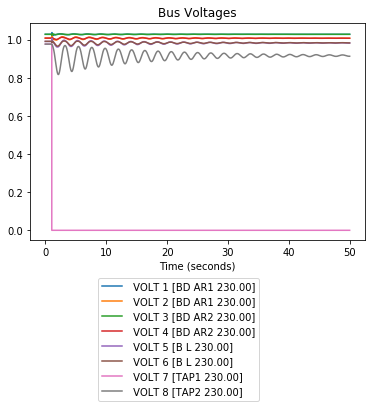

Task 2: Identify the time at which the disturbance occurs
Time of disturbance:1.05
----------------------
Task 3: Identify whether or not the system remains stable
It is a stable system
----------------------
Task 4: Do all voltages restore in accordance with PJM criteria?Task 5: Does the system stabilize with sufficient damping per PJM criteria?

Recovery time for  ETRM 1[BD AR1 230.00]1: 0 s ->PJM Criteria satisfied
Recovery time for  ETRM 2[BD AR1 230.00]1: 0 s ->PJM Criteria satisfied
Recovery time for  ETRM 3[BD AR2 230.00]1: 0 s ->PJM Criteria satisfied
Recovery time for  ETRM 4[BD AR2 230.00]1: 0 s ->PJM Criteria satisfied
----------------------
Task 5: Does the system stabilize with sufficient damping per PJM criteria?
 SPD 1[BD AR1 230.00]1:-2.22% -> PJM Criteria satisfied
 SPD 2[BD AR1 230.00]1:-2.22% -> PJM Criteria satisfied
 SPD 3[BD AR2 230.00]1:-2.22% -> PJM Criteria satisfied
 SPD 4[BD AR2 230.00]1:-2.23% -> PJM Criteria satisfied
----------------------


In [74]:
inn=compile(72)

In [80]:
def writedoc(n):
    inn=compile(n)
    document = Document()
    p0 = document.add_paragraph()
    r0 = p0.add_run()
    r0.add_text(f'Simulation number: {n} Analysis Report')
    p = document.add_paragraph()
    r = p.add_run()
    r.add_text('Task 1: Create graphic plot of power system variables')
    ims=['docs/genvol.jpg','docs/genpow.jpg','docs/gensp.jpg','docs/genbus.jpg']
    for i in range(len(ims)):
        r.add_picture(ims[i],width=Inches(3))
    for x in inn.split('\n'):
        p2 = document.add_paragraph()
        r2 = p2.add_run()
        r2.add_text(x)
    document.save(f'docs/{n}_output.docx')    
    return None

# User Defined Demo

In [87]:
ninput=input('What simulation do you want to analyze? ')

What simulation do you want to analyze? 3


---------Simulation Number:3------------
Task 1: Create graphic plot of power system variables


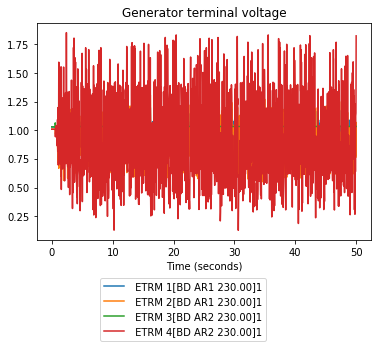

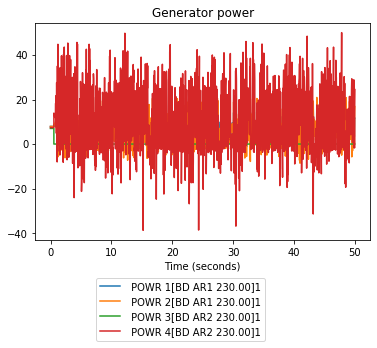

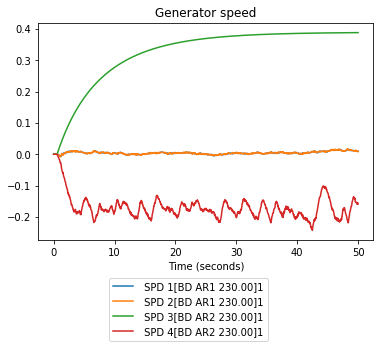

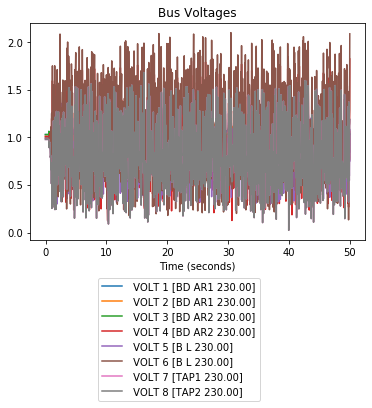

Task 2: Identify the time at which the disturbance occurs
Time of disturbance:0.55
----------------------
Task 3: Identify whether or not the system remains stable
Unstable system
Task 4 & 5: Skipped
----------------------


In [88]:
writedoc(ninput)